#### Выполнил: Глухов Елисей Александрович.

Мультивариативный ряд для решения `задачи регрессии`: погодные условия в некотором городе.

Задача направлена на предсказания следующих величин: температура воздуха, атмосферное давление, влажность, скорость ветра, угол ветра.

Временные характеритики: данные были собраны за полные 2015-2018 года, замеры брались каждый час.

In [217]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.var_model import VAR

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import grangercausalitytests

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from pmdarima import auto_arima

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

import torch
import torch.nn as nn

import warnings

Некоторые функции вызявают очень много warning'ов, из-за чего выходные данные ячеек сильно растягиваются.

In [27]:
warnings.filterwarnings("ignore")

В исходных данных в дате фигурирует часовой пояс, который в нашей задаче не нужен, поэтому мы его убираем.

In [2]:
def delete_time_zone(datetime):
    return datetime[:-6]

In [3]:
df = pd.read_csv("FinalProjectData/weather.csv", sep = ",",decimal =".")

df['dt_iso'] = df['dt_iso'].apply(delete_time_zone)

df['dt_iso'] = pd.to_datetime(df.dt_iso , format = '%Y-%m-%d %H:%M:%S')
#df = df.sort_values(by='dt_iso')
df = df.set_index('dt_iso')

В исходных данных были собраны данные с нескольких городов и склеины подряд, в один большой ряд. Я выбрал только замеры из первого места, так как данные из одного места могут никак не влиять на данные из другого места и совмещать их не имеет смысла (в общем случае).

In [4]:
df = df[:35145]

### Блок предбоработки временного ряда

In [5]:
df.head()

,temp,pressure,humidity,wind_speed,wind_deg
dt_iso,,,,,
2015-01-01 00:00:00,270.475,1001,77,1,62
2015-01-01 01:00:00,270.475,1001,77,1,62
2015-01-01 02:00:00,269.686,1002,78,0,23
2015-01-01 03:00:00,269.686,1002,78,0,23
2015-01-01 04:00:00,269.686,1002,78,0,23


In [6]:
df.describe()

,temp,pressure,humidity,wind_speed,wind_deg
count,35145.000000,35145.000000,35145.000000,35145.000000,35145.000000
mean,290.780780,1015.973794,65.145113,2.692815,160.753820
std,7.231284,11.927677,19.689276,2.581825,120.436402
min,268.830656,969.000000,8.000000,0.000000,0.000000
25%,285.150000,1012.000000,51.000000,1.000000,50.000000
50%,290.170000,1017.000000,67.000000,2.000000,130.000000
75%,296.150000,1021.000000,82.000000,4.000000,280.000000
max,311.150000,1087.000000,100.000000,133.000000,360.000000


Смотрим на графики считанных временных рядов.

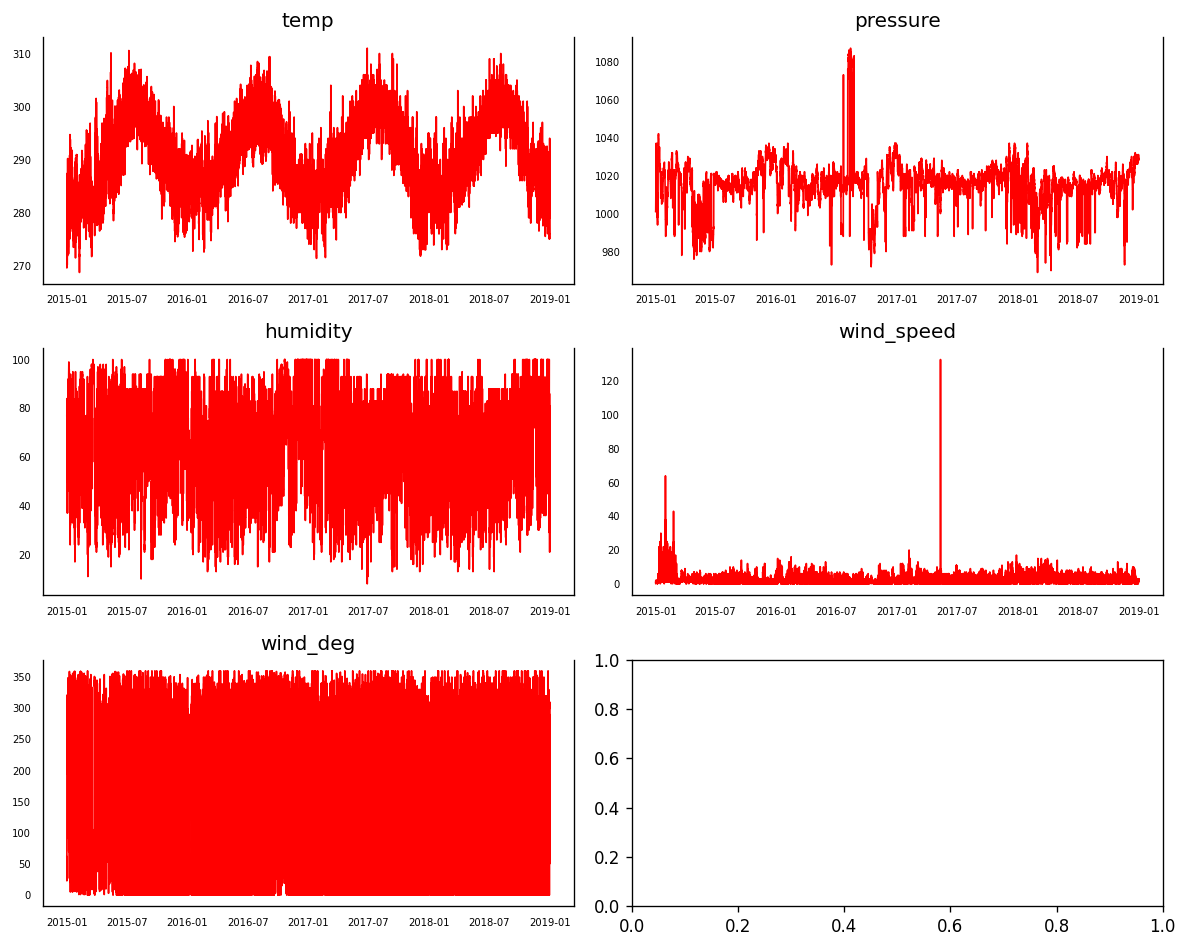

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,8))
for i, ax in enumerate(axes.flatten()):
    if i < 5:
        data = df[df.columns[i]]
        ax.plot(data, color='red', linewidth=1)
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)
plt.tight_layout()

По графикам не видно, что бы в данных были пропуски, но всё равно сделаем на это проверку.

In [10]:
skips = df.isnull().sum()
skips

temp          0
pressure      0
humidity      0
wind_speed    0
wind_deg      0
dtype: int64

Пропусков нет.

In [11]:
print(df.index.freq)

None


In [12]:
df.shape

(35145, 5)

#### Стационарность

Проверим наши ряды на стационарность.

In [21]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 9), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [219]:
train = df[:int(0.9 * (len(data)))]
test = df[int(0.9 * (len(data))):]

In [17]:
print(train.shape)

(31630, 5)


In [22]:
for name, column in train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "temp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.4026
 No. Lags Chosen       = 51
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 3.345e-06. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pressure" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.8795
 No. Lags Chosen       = 51
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "humidity" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance 

Все ряды стационарные => для предсказаний моделями VAR и VARMAX привидение к стационарным рядам (дифференцирование) проводить не надо.

#### Коинтеграция

Теперь проверим ряды на коинтеграцию - существование некоторой стационарной линейной комбинации этих самых рядов. Если такие комбинации есть, то в таком случае модели VAR и VARMAX должны неплохо их предсказывать.

In [ ]:
def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [ ]:
cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
temp   ::  7516.64   > 60.0627   =>   True
pressure ::  3681.26   > 40.1749   =>   True
humidity ::  1822.33   > 24.2761   =>   True
wind_speed ::  192.04    > 12.3212   =>   True
wind_deg ::  0.0       > 4.1296    =>   False


Тест Грейнджера на причинность

In [23]:
maxlag=12
tst = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [28]:
grangers_matrix = grangers_causation_matrix(df, variables=df.columns)
grangers_matrix

,temp_x,pressure_x,humidity_x,wind_speed_x,wind_deg_x
temp_y,1.0,0.0,0.0,0.0,0.0000
pressure_y,0.0,1.0,0.0,0.0,0.0464
humidity_y,0.0,0.0,1.0,0.0,0.0000
wind_speed_y,0.0,0.0,0.0,1.0,0.0000
wind_deg_y,0.0,0.0,0.0,0.0,1.0000


## Классические модели

### VAR

Для VAR модели важен порядок - число, которое характеризует набор предыдущих значений, которые модель использует для предсказаний следующих значений.

Подберём его с помощью специального метода и выбирем то, где лучше всего метрики AIC (Akaike Information Criterion), BIC (Bayesian Information Criterion), FPE (Final Prediction Error) и HQC (Hannan-Quinn Criterion).

In [220]:
model = VAR(train)
x = model.select_order(maxlags=100)
x.summary()

,AIC,BIC,FPE,HQIC
0,25.94,25.94,1.836e+11,25.94
1,16.43,16.44,1.367e+07,16.43
2,16.06,16.08,9.451e+06,16.07
3,15.93,15.96,8.317e+06,15.94
4,15.88,15.91,7.879e+06,15.89
5,15.87,15.90,7.780e+06,15.88
6,15.85,15.90,7.685e+06,15.87
7,15.84,15.89,7.606e+06,15.86
8,15.83,15.89,7.522e+06,15.85
9,15.83,15.89,7.475e+06,15.85


Выбираем наилучшее число - 98 и обучаем модель.

In [221]:
model_fitted = model.fit(98)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 10, Jan, 2024
Time:                     19:09:07
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    15.9996
Nobs:                     31532.0    HQIC:                   15.5571
Log likelihood:          -463244.    FPE:                4.63335e+06
AIC:                      15.3488    Det(Omega_mle):     4.28887e+06
--------------------------------------------------------------------
Results for equation temp
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  1.589407         0.752275            2.113           0.035
L1.temp                0.828294         0.006929          119.548           0.000
L1.pressure           -0.020223         0.002269         

Готовим данные для проверки предсказаний.

In [222]:
def create_dataset(test, in_seq, for_len, step):
    testX = []
    testY = []
    for i in range(0, len(test) - for_len - in_seq, step):
        testX.append(test[i:(i + in_seq)].to_numpy())
        testY.append(test[(i + in_seq):(i + in_seq + for_len)].to_numpy())
    return testX, testY

In [223]:
X_test, Y_test = create_dataset(test, 98, 1, 1)
X_train, Y_train = create_dataset(train, 98, 1, 1)

Делаем предсказания.

In [224]:
predictions = []

for x in X_test:
    predictions += [model_fitted.forecast(y=x,steps=1)]

In [225]:
predictions = np.array(predictions)
Y_test = np.array(Y_test)

In [226]:
print(predictions.shape)

(3416, 1, 5)


Отрисовываем предсказания.

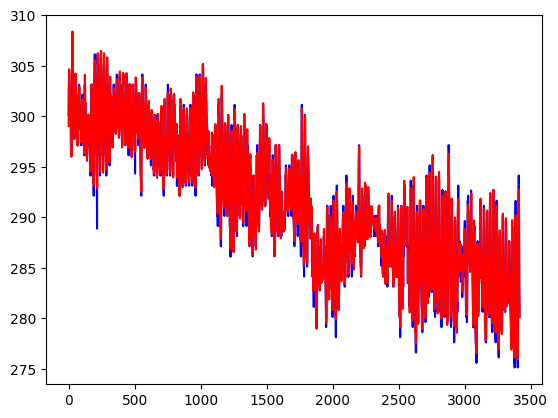

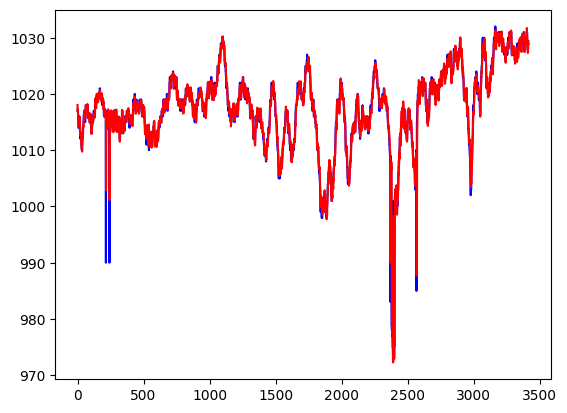

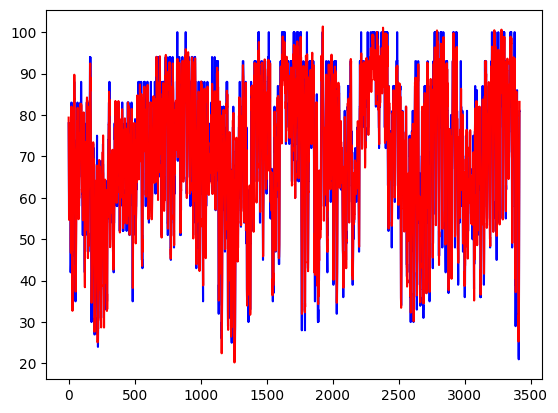

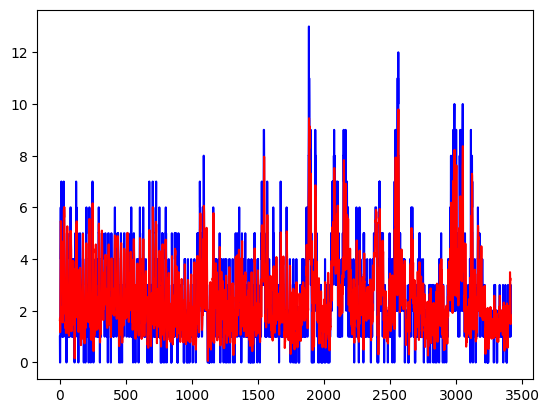

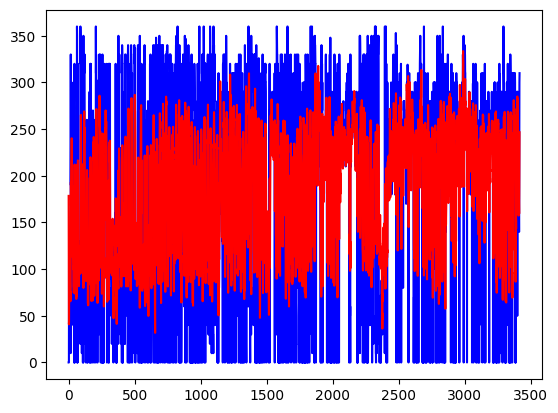

In [227]:
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    plt.plot(Y_test[:,:,i], color="b", label="original")
    plt.plot(predictions[:,:,i], color="r", label="predicted")
    plt.show()

Считаем метрики по предсказаниям

In [228]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)
    r2 = r2_score(actual, forecast)
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax, 'R^2':r2})

In [229]:
cols = test.columns.to_list()

for vi in range(len(cols)):
    print(f'Forecast Accuracy of: {cols[vi]}')
    n1 = f"{cols[vi]}_forecast"
    accuracy_prod = forecast_accuracy(predictions[:,:,vi], Y_test[:,:,vi])
    for k, v in accuracy_prod.items():
        print(k, ': ', round(v,4))
    print('')

Forecast Accuracy of: temp
mape :  0.0023
me :  0.038
mae :  0.668
mpe :  0.0001
rmse :  0.8991
corr :  nan
minmax :  0.0023
R^2 :  0.9829

Forecast Accuracy of: pressure
mape :  0.0007
me :  0.0164
mae :  0.6718
mpe :  0.0
rmse :  1.695
corr :  nan
minmax :  0.0007
R^2 :  0.9471

Forecast Accuracy of: humidity
mape :  0.0656
me :  -0.5078
mae :  4.2662
mpe :  0.001
rmse :  5.8568
corr :  nan
minmax :  0.0609
R^2 :  0.8842

Forecast Accuracy of: wind_speed
mape :  inf
me :  -0.0076
mae :  0.8537
mpe :  inf
rmse :  1.1393
corr :  nan
minmax :  0.3062
R^2 :  0.5545

Forecast Accuracy of: wind_deg
mape :  inf
me :  -6.9111
mae :  70.1819
mpe :  inf
rmse :  94.928
corr :  nan
minmax :  0.3437
R^2 :  0.3238



Метрики предсказаний, в целом, хорошие: mape, me, mae, mpe для всех рядов (кроме последнего) почти < 2 (у некоторых вообще < 1, а где inf - там в исходном ряде были нули, из-за чего появилось деление на ноль). R^2 же только для первых трёх рядов очень хороший (для первых двух вообще 0.95+, а для второго - 0.89), для других же он сильно меньше 1, что указывает на неточное предсказание.

Однако, если посмотреть их графики, ряды (если смотреть их по порядку) к концу становятся всё более "случайными". И действительно: скорость ветра и его угол очень сильно меняются в течение дня, хотя другие показатели, такие как температура, давление и влажность, не успевают сильно измениться, из-за чего модели трудно понять, как они будут себя вести в будущем.

Скорость ветра вообще больше зависит от конкретной местности и наличие рек/морей/океанов, нежели от рассматриваемых величин. Про угол ветра вообще другая история - он в течение дня меняется очень часто, и зависит от температуры/давления в соседних областях.

### VARMAX

Сначала надо выбрать нужный порядок для нашей модели. С этим поможет функция auto_arima. Она будет предсказывать числа p, d, q для модели ARIMA. Нам же нужны только p и q для нашей модели. Учтём это при формировании порядка.

In [165]:
pq = []
for name, column in df.items():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(df[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : temp
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=120721.494, Time=2.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=125709.621, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=122356.286, Time=0.65 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=123471.907, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=125707.622, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=120089.566, Time=2.62 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=120244.044, Time=0.88 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=119901.618, Time=4.60 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=119957.963, Time=1.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=114784.340, Time=23.72 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=119780.641, Time=1.43 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=114388.941, Time=24.39 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=119330.960, Time=1.78 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept

Лучшие коэффициенты предсказались для ARIMA модели, где 3 коэффициента: p, d, q. Нам же нужны только p и q, поэтому будем выбирать только среди них.

In [166]:
print(pq)

[(7, 1, 1), (3, 1, 1), (7, 1, 2), (7, 1, 4), (4, 1, 1)]


Было решено выбрать p и q равными 7 и 1 соответственно, так как в большинстве случаев они показали себя лучше всего (можно было бы добавить перебор параметров, но VARMAX модель обучается очень долго (эта модель обучалась 83 минуты), поэтому это бы заняло очень много времени).

In [ ]:
model = VARMAX(train, order=(7, 1))
model = model.fit(disp=True)

Делаем предсказания.

In [ ]:
forecast = model.forecast(steps=len(test))

In [182]:
forecast = np.array(forecast)

In [183]:
print(forecast.shape)

(3515, 5)


In [189]:
print(forecast)

[[ 296.45478578 1012.16627254   74.85299396    1.407714    219.78741709]
 [ 296.8520878  1012.16203856   72.39645871    1.56319466  200.0564073 ]
 [ 297.41689706 1012.26228938   69.78223655    1.60292892  187.03851962]
 ...
 [ 290.67072504 1015.79631537   64.4405674     2.70795439  157.69127316]
 [ 290.67072504 1015.79631537   64.4405674     2.70795439  157.69127316]
 [ 290.67072504 1015.79631537   64.4405674     2.70795439  157.69127316]]


Ортисовываем предсказания.

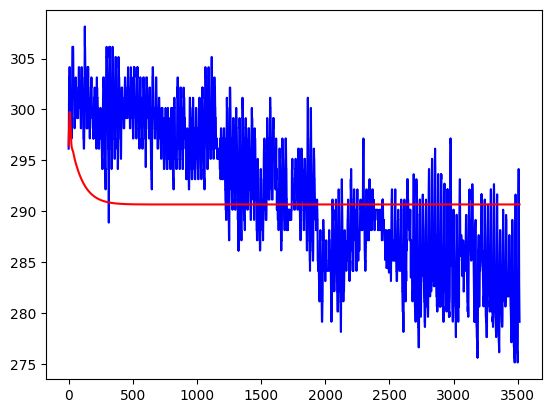

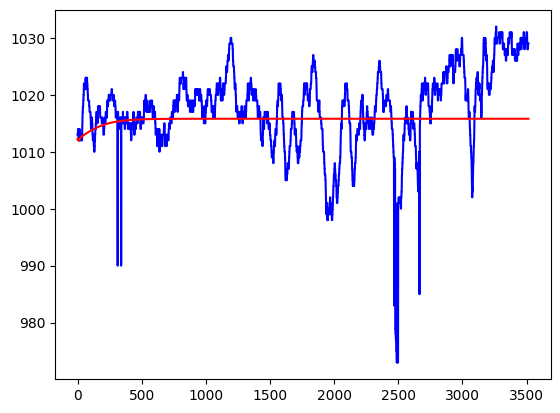

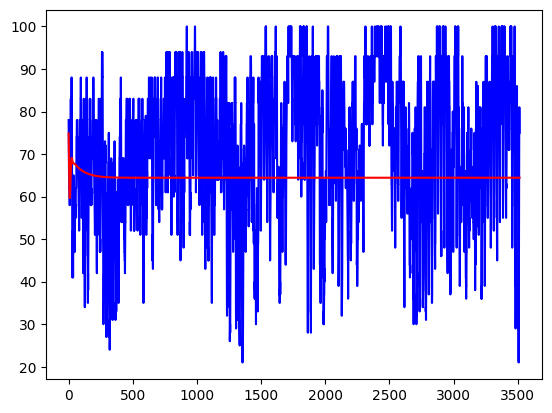

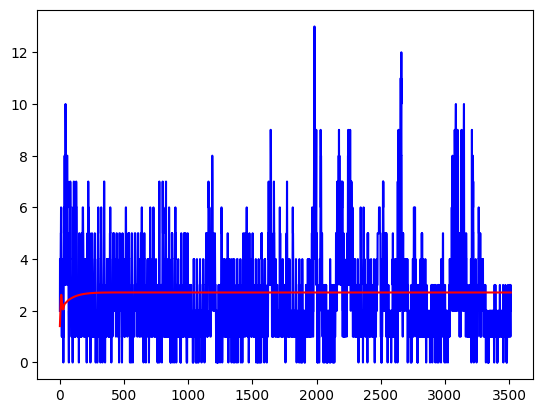

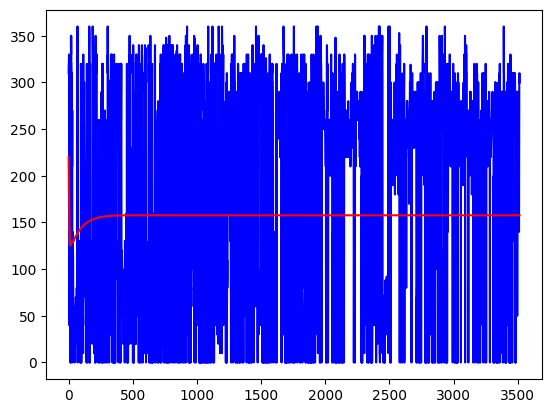

In [192]:
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    plt.plot(np.array(test)[:,i], color="b", label="original")
    plt.plot(forecast[:,i], color="r", label="predicted")
    plt.show()

In [ ]:
for vi in range(len(cols)):
    print(f'Forecast Accuracy of: {cols[vi]}')
    n1 = f"{cols[vi]}_forecast"
    accuracy_prod = forecast_accuracy(forecast[:,vi], np.array(test)[:,vi])
    for k, v in accuracy_prod.items():
        print(k, ': ', round(v,4))
    print('')

Forecast Accuracy of: temp
mape :  0.0197
me :  -0.8869
mae :  5.7602
mpe :  -0.0025
rmse :  6.8229
corr :  0.2928
minmax :  0.0195
R^2 :  0.0419

Forecast Accuracy of: pressure
mape :  0.0054
me :  -1.9226
mae :  5.4729
mpe :  -0.0018
rmse :  7.535
corr :  0.0545
minmax :  0.0054
R^2 :  -0.067

Forecast Accuracy of: humidity
mape :  0.2338
me :  -6.9428
mae :  15.5466
mpe :  -0.0267
rmse :  18.4937
corr :  -0.0585
minmax :  0.1969
R^2 :  -0.17

Forecast Accuracy of: wind_speed
mape :  inf
me :  0.1352
mae :  1.3713
mpe :  inf
rmse :  1.7495
corr :  -0.1112
minmax :  0.3999
R^2 :  -0.0175

Forecast Accuracy of: wind_deg
mape :  inf
me :  -31.5071
mae :  110.5438
mpe :  inf
rmse :  119.5541
corr :  0.124
minmax :  0.4997
R^2 :  -0.0663



C:\Users\elise\AppData\Local\Temp\ipykernel_10564\1815074186.py:4: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
C:\Users\elise\AppData\Local\Temp\ipykernel_10564\1815074186.py:7: RuntimeWarning: divide by zero encountered in divide
  mpe = np.mean((forecast - actual)/actual)   # MPE
C:\Users\elise\AppData\Local\Temp\ipykernel_10564\1815074186.py:4: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
C:\Users\elise\AppData\Local\Temp\ipykernel_10564\1815074186.py:7: RuntimeWarning: divide by zero encountered in divide
  mpe = np.mean((forecast - actual)/actual)   # MPE


Предсказания моделью VARMAX больше похожи на устреднённую линию некого усреднённого значения временного ряда. Из-за этого эта модель, по факту, никак не предсказывает ряд, из-за чего метрики такие плохие. Единственное, что можно выделить - это метрики для температуры (Temp), у него mape, me, mae и mpe относительно нормальные для значений, которые принимают значения около 300.

Если же посмотреть на R^2 (оно у всех близко к 0), то сразу видно, что такая модель плохо предсказывает значения.

## Нейросети

### LSTM

In [107]:
test_size=int(len(df) * 0.2)
test_size

7029

In [108]:
train_df = df[:-test_size]
test_df = df[-test_size:]

print(train_df.shape)
print(test_df.shape)

(28116, 5)
(7029, 5)


Нормируем данные, так как они изначально не нормированные (было видно в df.head()).

In [109]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_df_scaled = scaler.fit_transform(train_df)
test_df_scaled = scaler.transform(test_df)

In [110]:
train_df_scaled

array([[0.03885561, 0.27118644, 0.75      , 0.0075188 , 0.17222222],
       [0.03885561, 0.27118644, 0.75      , 0.0075188 , 0.17222222],
       [0.02021165, 0.27966102, 0.76086957, 0.        , 0.06388889],
       ...,
       [0.52740288, 0.30508475, 0.51086957, 0.02255639, 0.22222222],
       [0.52740288, 0.29661017, 0.51086957, 0.0075188 , 0.        ],
       [0.50377302, 0.29661017, 0.64130435, 0.01503759, 0.11111111]])

In [111]:
test_df_scaled

array([[0.48014317, 0.29661017, 0.69565217, 0.01503759, 0.80555556],
       [0.48014317, 0.28813559, 0.69565217, 0.0075188 , 0.86111111],
       [0.43288346, 0.27966102, 0.80434783, 0.06015038, 0.67777778],
       ...,
       [0.30315555, 0.50847458, 0.79347826, 0.02255639, 0.83333333],
       [0.26723816, 0.50847458, 0.79347826, 0.01503759, 0.86111111],
       [0.24360831, 0.50847458, 0.72826087, 0.01503759, 0.83333333]])

Создаём датасет из данных.

In [112]:
def createXY(dataset, n_past, col_to_forecast = 0):
    dataX = []
    dataY = []
    for i in range(0, len(dataset) - n_past):
            dataX.append(dataset[i:i + n_past, 0:dataset.shape[1]])
            dataY.append(dataset[i + n_past, col_to_forecast])
    return np.array(dataX),np.array(dataY) 

In [119]:
n_past = 24

X_train, Y_train = createXY(train_df_scaled, n_past, 0)
X_test, Y_test = createXY(test_df_scaled, n_past, 0)

In [120]:
X_train.shape

(28092, 24, 5)

In [121]:
X_test.shape

(7005, 24, 5)

Из лучших параметров для модели были выбраны: batch_size = 20, epochs = 10, optimizer = Adadelta. Перебор grid_search занял много времени, но посчитал эти параметры лучшими. К сожалению, та ячейка была по ошибке удалена и лог grid_search потерялся, поэтому я решил провести grid_search по одному набору параметров для оптимизации времени.

P.S. grid_search перебирал среди batch_size [16, 20], epochs [8, 10] и oprimizer ['Adam', 'Adadelta']

In [123]:
def build_model(optimizer="adam", n_past = n_past, icol = 5):
    grid_model = Sequential()
    grid_model.add(LSTM(20 + n_past,return_sequences=True,input_shape=(n_past, icol)))
    grid_model.add(LSTM(20 + n_past))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse', optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(model=build_model,verbose=1, fit__validation_data=(X_test, Y_test))

parameters = {'batch_size' : [20],
              'epochs' : [10],
              'optimizer' : ['Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

In [124]:
grid_search = grid_search.fit(X_train, Y_train)

Epoch 1/10
703/703 [==============================] - 7s 8ms/step - loss: 0.0097 - val_loss: 0.0021
Epoch 2/10
703/703 [==============================] - 5s 7ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 3/10
703/703 [==============================] - 5s 6ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 4/10
703/703 [==============================] - 5s 7ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 5/10
703/703 [==============================] - 5s 7ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 6/10
703/703 [==============================] - 5s 7ms/step - loss: 0.0015 - val_loss: 7.0046e-04
Epoch 7/10
703/703 [==============================] - 5s 7ms/step - loss: 0.0012 - val_loss: 9.2510e-04
Epoch 8/10
703/703 [==============================] - 5s 7ms/step - loss: 0.0011 - val_loss: 6.0019e-04
Epoch 9/10
703/703 [==============================] - 5s 7ms/step - loss: 0.0010 - val_loss: 6.0205e-04
Epoch 10/10
703/703 [==============================] - 2s 2ms/step
Epoch 1/10
703/70

In [125]:
grid_search.best_params_

{'batch_size': 20, 'epochs': 10, 'optimizer': 'Adadelta'}

Заполняем модель лучшими результатами.

In [126]:
my_model=grid_search.best_estimator_.model
my_model

<function __main__.build_model(optimizer='adam', n_past=24, icol=5)>

In [127]:
prediction=grid_search.best_estimator_.predict(X_test)

print(f"prediction {prediction} \n")
print(f"Prediction Shape {prediction.shape}")

351/351 [==============================] - 1s 2ms/step
prediction [0.4802593  0.46686527 0.44828627 ... 0.30160987 0.27213177 0.25189325] 

Prediction Shape (7005,)


Меняем предсказанные значения обратно из [0, 1] -> [0, inf]

In [128]:
pred = prediction.reshape(-1, 1)

prediction_copies_array = np.repeat(pred,5, axis=-1)
prediction_copies_array.shape

(7005, 5)

In [129]:
cfs = len(df.columns)

prediction=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction_copies_array),cfs)))[:,0]
prediction

array([289.1549 , 288.58807, 287.80185, ..., 281.59457, 280.34708,
       279.4906 ], dtype=float32)

In [130]:
original_copies_array = np.repeat(Y_test.reshape(-1, 1),cfs, axis=-1)
original_copies_array.shape

(7005, 5)

In [131]:
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(Y_test),cfs)))[:,0]

In [132]:
print(f"Pred Values-- {prediction}\n\n")
print(f"Original Values-- {original}")

Pred Values-- [289.1549  288.58807 287.80185 ... 281.59457 280.34708 279.4906 ]


Original Values-- [289.15 288.15 287.15 ... 281.66 280.14 279.14]


Отрисовываем предсказания.

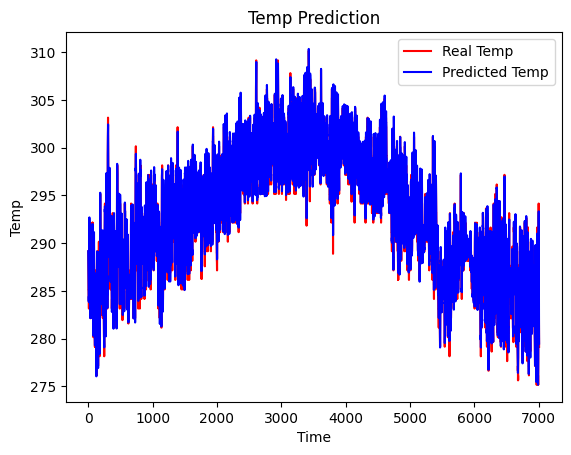

In [133]:
plt.plot(original, color = 'red', label = 'Real Temp')
plt.plot(prediction, color = 'blue', label = 'Predicted Temp')
plt.title('Temp Prediction')
plt.xlabel('Time')
plt.ylabel('Temp')
plt.legend()
plt.show()

In [200]:
print('LSTM metrics:')
metrics = forecast_accuracy(prediction, original)
metric_names = metrics.keys()
for metric in metric_names:
    print(metric, '=', metrics[metric])

LSTM metrics:
mape = 0.002525452001180719
me = 0.10222273086887519
mae = 0.7387780091856839
mpe = 0.0003538894364472667
rmse = 1.0070164935302863
corr = 0.9889735925174593
minmax = 0.002518844345375637
R^2 = 0.977672050420369


Метрики для ряда Temp, предсказанные с помощью LTSM, лучше, чем у классических моделей, что даже видно по графику предсказания. Метрики mape, me, mae, mpe, rmse ВСЕ(!) < 1, причем первые 3 сильно меньше, чем 1.

Ну и понятное дело, что R^2 тоже очень хороший - почти 0.98, что является отличным результатом.

#### Elman RNN

Так как мы имеем дело с Elman RNN (рекурентной сетью Элмана), нам надо создать свою модель, используя torch.nn.

In [207]:
class ElmanRNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(1, 50, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, a = self.rnn(x)
        x = self.linear(x)
        return x

In [170]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [171]:
def data_split(ts, param="0", train_percentage=0.8):
    timeseries = ts[ts.columns[int(param)]].values.astype('float32')
    train_size = int(len(timeseries) * train_percentage)
    train, test = timeseries[:train_size], timeseries[train_size:]
    return train, test, timeseries

Задём функцию, в которой будет происходить обучение модели и сразу же её валидация.

In [172]:
def train_model(model, loader, optimizer, loss_fn, X_train, X_test, y_train, y_test, n_epochs):
    y_pred_train = None
    y_pred_test = None

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred_train = y_pred
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            y_pred = model(X_test)
            y_pred_test = y_pred
            test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    return y_pred_train, y_pred_test, model

In [178]:
GRU_df = df.copy()

train, test, total = data_split(GRU_df)
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

Я выбрал оптимизатор Adamax, так как Adam и Adadelta, почему-то, делали предсказания в виде прямой линии, и имели RMSE ~7.24 и не меняли его, что странно.

In [209]:
model = ElmanRNNModel()
optimizer = torch.optim.Adamax(model.parameters())
loss_fn = nn.MSELoss()
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

EPOCHS = 30

y_pred_train, y_pred_test, model = train_model(model, loader, optimizer, loss_fn, X_train, X_test, y_train, y_test, EPOCHS)

Epoch 0: train RMSE 7.5563, test RMSE 8.3667
Epoch 1: train RMSE 6.5153, test RMSE 6.0500
Epoch 2: train RMSE 4.4718, test RMSE 5.1501
Epoch 3: train RMSE 2.4992, test RMSE 2.7063
Epoch 4: train RMSE 2.2368, test RMSE 2.0367
Epoch 5: train RMSE 1.7788, test RMSE 1.6839
Epoch 6: train RMSE 2.4588, test RMSE 2.5068
Epoch 7: train RMSE 2.5998, test RMSE 2.6551
Epoch 8: train RMSE 1.8184, test RMSE 1.7644
Epoch 9: train RMSE 1.9829, test RMSE 1.7475
Epoch 10: train RMSE 1.5715, test RMSE 1.3947
Epoch 11: train RMSE 1.5755, test RMSE 1.4043
Epoch 12: train RMSE 1.6250, test RMSE 1.4058
Epoch 13: train RMSE 1.7563, test RMSE 1.6692
Epoch 14: train RMSE 1.5579, test RMSE 1.3746
Epoch 15: train RMSE 1.8677, test RMSE 1.7918
Epoch 16: train RMSE 1.5945, test RMSE 1.4473
Epoch 17: train RMSE 1.6049, test RMSE 1.4422
Epoch 18: train RMSE 1.8857, test RMSE 1.8163
Epoch 19: train RMSE 3.1701, test RMSE 3.0186
Epoch 20: train RMSE 2.1363, test RMSE 1.8580
Epoch 21: train RMSE 1.7688, test RMSE 1.595

Отрисовывваем предсказания и оригинальные данные.

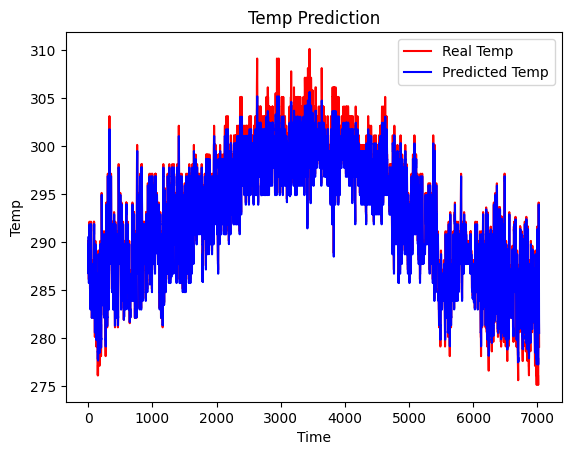

In [210]:
plt.plot(y_test, color = 'red', label = 'Real Temp')
plt.plot(y_pred_test, color = 'blue', label = 'Predicted Temp')
plt.title('Temp Prediction')
plt.xlabel('Time')
plt.ylabel('Temp')
plt.legend()
plt.show()

Считаем метрики для предсказания.

In [211]:
print('Elman RNN metrics:')
metrics = forecast_accuracy(y_pred_test.numpy(), y_test.numpy())
metric_names = metrics.keys()
for metric in metric_names:
    print(metric, '=', metrics[metric])

Elman RNN metrics:
mape = 0.0035556122
me = -0.4261412
mae = 1.0438747
mpe = -0.0014159116
rmse = 1.4085873147200736
corr = nan
minmax = 0.003550231456756592
R^2 = 0.9562305198782869


Рекурентная нейронная сеть Элмана себя показала немного хуже, чем LSTM, однако она всё равно предсказывает значения очень хорошо: mape, me, mae и mpe около единицы и менее.

R^2 равен 0.95, что тоже довольно хорошо.

### GRU

Это также особая рекурентная сеть, которая есть в torch.nn, поэтому создадим свой класс

In [202]:
class GRUModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(1, 50, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, a = self.gru(x)
        x = self.linear(x)
        return x

Воспользуемся уже ранее созданной функцией для обучения моделей и её валидации. Будем использовать те же оптимизатор и лосс функцию.

In [203]:
model = GRUModel()
optimizer = torch.optim.AdamW(model.parameters())
loss_fn = nn.MSELoss()
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

EPOCHS = 30

y_pred_train, y_pred_test, model = train_model(model, loader, optimizer, loss_fn, X_train, X_test, y_train, y_test, EPOCHS)

Epoch 0: train RMSE 42.0685, test RMSE 44.7574
Epoch 1: train RMSE 6.8812, test RMSE 7.1277
Epoch 2: train RMSE 5.3275, test RMSE 5.0616
Epoch 3: train RMSE 3.9508, test RMSE 2.8639
Epoch 4: train RMSE 8.9630, test RMSE 6.9925
Epoch 5: train RMSE 3.4555, test RMSE 2.0953
Epoch 6: train RMSE 1.7886, test RMSE 1.5590
Epoch 7: train RMSE 3.0076, test RMSE 2.7373
Epoch 8: train RMSE 2.3606, test RMSE 2.2960
Epoch 9: train RMSE 1.6758, test RMSE 1.5359
Epoch 10: train RMSE 2.0488, test RMSE 2.0405
Epoch 11: train RMSE 1.4953, test RMSE 1.3158
Epoch 12: train RMSE 1.6620, test RMSE 1.3993
Epoch 13: train RMSE 1.5412, test RMSE 1.3194
Epoch 14: train RMSE 1.7579, test RMSE 1.5091
Epoch 15: train RMSE 1.4853, test RMSE 1.2690
Epoch 16: train RMSE 1.6283, test RMSE 1.4943
Epoch 17: train RMSE 1.6980, test RMSE 1.5908
Epoch 18: train RMSE 1.5108, test RMSE 1.3201
Epoch 19: train RMSE 2.8090, test RMSE 2.5080
Epoch 20: train RMSE 1.5047, test RMSE 1.2811
Epoch 21: train RMSE 1.5106, test RMSE 1.3

Смотрим предсказания.

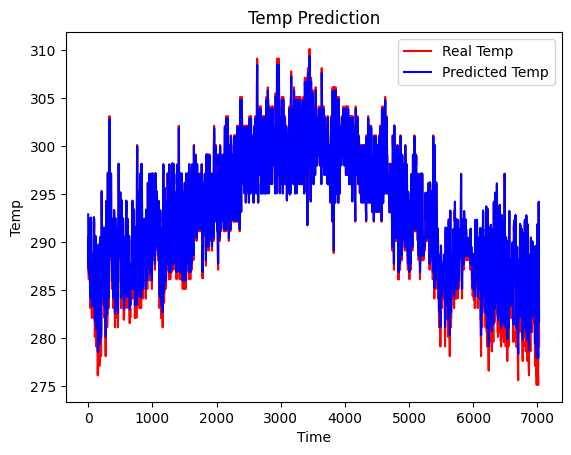

In [205]:
plt.plot(y_test, color = 'red', label = 'Real Temp')
plt.plot(y_pred_test, color = 'blue', label = 'Predicted Temp')
plt.title('Temp Prediction')
plt.xlabel('Time')
plt.ylabel('Temp')
plt.legend()
plt.show()

Считаем метрики для предсказания.

In [204]:
print('GRU metrics:')
metrics = forecast_accuracy(y_pred_test.numpy(), y_test.numpy())
metric_names = metrics.keys()
for metric in metric_names:
    print(metric, '=', metrics[metric])

GRU metrics:
mape = 0.0034825108
me = 0.2900644
mae = 1.0135609
mpe = 0.0010393546
rmse = 1.3486382044436473
corr = nan
minmax = 0.0034686923027038574
R^2 = 0.9598768730533599


В целом, результат очень схож с Elman RNN, однако у этой нейросети mape, me, mae, mpe и rmse немного поменьше, так что можно сказать, что эта нейросеть предсказывает результаты немного по-лучше.

R^2 также по-больше на 0.003, что не сильно критично, но всё равно больше.

### Итоговый вывод

Если расматривать отдельно классические модели, то среди них очевидно впереди модель VAR. Хоть у неё и были проблемы с двумя последними рядами (мы уже поняли, почему так вышло, но всё же), она по всем фронтам обходит VARMAX модель: она училась буквально несколько секунд, в то время как VARMAX училась аж 83(!!!) минуты, и получила просто ужасные, по сравнению с VAR, результаты, метрики по всем рядам у VAR на порядок лучше (особенно R^2). Честно говоря, я так и не понял, что пошло не так с VARMAX моделью. Единственное, что там можно в теории менять - это order (порядок). Я выбрал оптимальный среди всех предложенных, но всё равно получил неудовлетворительный результат. Так что без оговорочное первенство среди классических моделей занимает VAR модель.

Если выбирать среди нейронных сетей, то лучшие метрики были у LTSM, хотя у других они тоже были довольно хорошие, но если сравнивать, то у LTSM - по-лучше. Также модель LTSM обучалась дольше всего (возможно, это из-за grid_search по одной паре параметров, и если бы я обучал сеть напрямую, то резлуьтат был бы другой, но сейчас имеет что имеем). Для проектов с большими наборами данных я бы, наверное, выбрал Elman RNN, так как она быстрее всех обучилась на данных (менее 2 минут, когда другие учились 3+ минут), и показала хорошие результаты и метрики к ним.

В итоге: все расмотренные нейросети показали себя лучше классических моделей, не только из-за лучших придсказаний и метрик по ним, а ещё из-за простоты передачи в них данных: при использовании моделей VAR и VARMAX нужно было проверять стационарность, нажна была коинтеграция между рядами, чтобы предсказания были хорошие, а для нейросетей ничего этого не нужно (хотя все мои ряды были стационарными и это никак не повлияло на результат, всё равно надо было проводить эти дополнительные проверки на стационарнось/коинтеграцию). Да и выбор в обучении у нейросетей куда больше: можно поиграться со слоями, изменить оптимизатор (что в моём случае очень сильно изменило резлуьтат, он был описан в Elman ENN), изменить параметры оптимизатора и т.д. Для классических же моделей такая детальная настрока невозможно. Единственное, что там можно изменить, 1-2 параметра у модели, а также размеры тренировочной/тестовой выборок, да и всё на этом.